In [2]:
import datetime
import glob
import os
import pickle as pkl

import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import properscoring as ps
import scipy.stats as stats
import seaborn as sns
from ipywidgets import *
from matplotlib import cm
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.integrate import quad
from scipy.stats import multivariate_normal, norm
from sklearn.neighbors import KernelDensity
from statsmodels.distributions.empirical_distribution import ECDF

from functional_utils import _fDepth, _fQuantile
from loading_utils import (
    _process_metadata,
    _process_testing_curves,
    _process_testing_forecasts,
    _process_training_curves,
    _process_traning_forecasts,
)
from scores_utils import *

plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.handleheight"] = 1.125
plt.rcParams["font.family"] = "Avenir"

path_to_fDepth = (
    "/Users/Guille/Desktop/dynamic_update/functional_forecast_dynamic_update/fDepth"
)
path_to_data = "/Users/Guille/Desktop/dynamic_update/data"
path_to_images = "/Users/Guille/Desktop/dynamic_update/images"

# Historical random curves and day-ahead forecasts

In [3]:
# Timestamps in interval
T = 288

# Loading color palette
palette_ = pd.read_csv(path_to_data + "/palette.csv")
print(palette_)

# Loading Texas map
TX_ = gpd.read_file(path_to_data + "/maps/TX/State.shp")

# Loading and processing of sites metadata
meta_ = _process_metadata(file_name="/wind_meta.xlsx", path=path_to_data)
assets_ = meta_.index
X_tr_ = meta_[["lon", "lat"]].to_numpy()
print(X_tr_.shape)

meta_ = meta_.reset_index(drop=False)
vals, idx_ = np.unique(X_tr_, return_index=True, axis=0)
assets_ = assets_[idx_]
X_tr_ = X_tr_[idx_, :]
print(assets_.shape)

idx_ = np.argsort(assets_)
assets_ = assets_[idx_]
X_tr_ = X_tr_[idx_, :]
print(assets_.shape)

# Loading and processing of historical curves for the training dataset
F_tr_, T_tr_, x_tr_, p_ = _process_training_curves(
    X_tr_,
    assets_,
    T,
    file_name="/actuals/wind_actual_5min_site_2017.csv",
    path=path_to_data,
)

print(F_tr_.shape, T_tr_.shape, x_tr_.shape, p_.shape)

# Loading and processing of historical curves for the testing dataset
F_ts_, T_ts_, x_ts_ = _process_testing_curves(
    X_tr_,
    assets_,
    p_,
    T,
    file_name="/actuals/wind_actual_5min_site_2018.csv",
    path=path_to_data,
)
print(F_ts_.shape, T_ts_.shape, x_ts_.shape)

# Loading and processing of historical day-ahead forecast for the training dataset
E_tr_ = _process_traning_forecasts(
    assets_,
    p_,
    T,
    file_name="/actuals/wind_day_ahead_forecast_2017.csv",
    path=path_to_data,
)
print(E_tr_.shape)

# Loading and processing of historical day-ahead forecast for the testing dataset
E_ts_ = _process_testing_forecasts(
    assets_,
    p_,
    T,
    file_name="/actuals/wind_day_ahead_forecast_2018.csv",
    path=path_to_data,
)
print(E_ts_.shape)

dt_ = np.array([t * 5 for t in range(T)])
dx_ = (
    pd.to_datetime(pd.DataFrame({"time": dt_}).time, unit="m")
    .dt.strftime("%H:%M")
    .to_numpy()
)
print(dt_.shape, dx_.shape)

t_ts_ = (
    np.array(
        [
            datetime.datetime.strptime(t_ts, "%Y-%m-%d").timetuple().tm_yday
            for t_ts in T_ts_
        ]
    )
    - 1
)
t_tr_ = (
    np.array(
        [
            datetime.datetime.strptime(t_tr, "%Y-%m-%d").timetuple().tm_yday
            for t_tr in T_tr_
        ]
    )
    - 1
)
print(t_tr_.shape, t_ts_.shape)

      miro      ibm
0  #013396  #648FFF
1  #B1C06E  #785EF0
2  #056534  #DC267F
3  #F80202  #FE6100
4  #FDD906  #FFB000
5  #FCF795      NaN
6  #CCEDFF      NaN
7  #FDD60B      NaN
8  #FCE9D0      NaN
(264, 2)
(187,)
(187,)
(104544, 187)
(67881, 288) (67881,) (67881, 2) (187,)
(105120, 1) (105120, 187)
0.0 1.0
(365, 288, 187) (365,) (187, 2)
0.0 0.9999999888984703
(67881, 288)
0.0 1.0
(365, 288, 187)
(288,) (288,)
(67881,) (365,)


# Functional kNNs dynamic update

In [10]:
# Calculate weighted (w_) distance between X_ and x_
def _euclidian_dist(X_, x_, w_=[]):
    if len(w_) == 0:
        w_ = np.ones(x_.shape)
    w_ = w_ / w_.sum()
    d_ = np.zeros((X_.shape[0],))
    for i in range(X_.shape[0]):
        d_[i] = w_.T @ (X_[i, :] - x_) ** 2
    return d_

# Radial Basis function kernel based on distance (d_)
def _kernel(d_, length_scale):
    w_ = np.exp(-d_ / length_scale)
    return w_  # /w_.sum()

def _inv_dist(d_, length_scale):
    w_ = 1.0 / (d_ + length_scale)
    return w_  # /w_.sum()

# Define exponential growth function
def _exponential_growth(t, dacay_rate, innit=0):
    tau_ = np.linspace(t - 1, 0, t)
    return np.exp(-dacay_rate * tau_)

# Define exponential dacay function
def _exponential_decay(S, dacay_rate):
    s_ = np.linspace(0, S - 1, S)
    return np.exp(-dacay_rate * s_)


def _haversine_dist(x_1_, x_2_):
    """
    Calculate the distance between two points on Earth using the Haversine formula.

    Args:
        x_1_ (float): Longitude and latitude of the first point in degrees.
        x_2_ (float): Longitude and latitude of the second point in degrees.

    Returns:
        float: Distance between the two points in kilometers.
    """
    R = 6371  # Radius of Earth in kilometers

    dlat_ = np.deg2rad(x_2_[:, 1]) - np.deg2rad(x_1_[1])
    dlon_ = np.deg2rad(x_2_[:, 0]) - np.deg2rad(x_1_[0])

    theta = (
        np.sin(dlat_ / 2) ** 2
        + np.cos(np.deg2rad(x_1_[1]))
        * np.cos(np.deg2rad(x_2_[:, 1]))
        * np.sin(dlon_ / 2) ** 2
    )

    return 2.0 * R * np.arcsin(np.sqrt(theta))


def _logistic(x_, k=1.0):
    return 1.0 / (1.0 + np.exp(-k * x_))


# # Fuse day-ahead forecast with real-time forecast
# def _update_forecast(F_ac_, f_hat_, fc_, update_rate):

#     w_update_ = 1. - _exponential_decay_plus(F_ac_.shape[1] + 1, update_rate)[1:]
#     #w_update_ = eta_/eta_.max()
#     f_update_ = f_hat_*(1. - w_update_) + fc_*w_update_

#     plt.figure(figsize = (10, 2))
#     plt.title('Trust Rate')
#     plt.plot(w_update_)
#     plt.show()

#     return f_update_


# Define a function to calculate quantiles
def _KDE_quantile(_KDE, q_, x_min=0.0, x_max=1.0, n_samples=1000):
    """
    Calculates the quantile for a given probability using KDE.

    Parameters:
    _KDE: Kernel density estimate object (e.g., from scipy.stats.gaussian_kde).
    q:    Probability value (between 0 and 1) for which to calculate the quantile.

    Returns:
    The quantile value.
    """

    # Calculate CDF
    x_ = np.linspace(x_min, x_max, n_samples)
    # z_ = np.exp(_KDE.score_samples(x_[:, np.newaxis]))
    w_ = np.cumsum(np.exp(_KDE.score_samples(x_[:, np.newaxis])))
    # Normalize CDF
    w_ /= w_[-1]

    return np.interp(np.array(q_), w_, x_), np.interp(1.0 - np.array(q_), w_, x_)


# Silverman's Rule
def _silverman_rule(x_):
    IQR = np.percentile(x_, 75) - np.percentile(x_, 25)
    return 0.9 * min(np.std(x_), IQR / 1.34) * x_.shape[0] ** (-1 / 5)


# Periodic distance to rank samples by day of the year
def _periodic_dist(x_1_, x_2_, day_to_degree=360/365, degree_to_rad=np.pi / 180):
    return np.sin(0.5 * (day_to_degree * (x_2_ - x_1_) * degree_to_rad) ) ** 2


# Filtering scenarios when they are above the upper threshold or below the lower threshold
def _scenario_filtering(W_, d_h_, d_p_, xi, gamma, kappa_min, kappa_max):

    status = 0
    sigma = 0

    # Similarity ranking
    idx_rank_ = np.argmin(W_, axis=0)

    # Similarity filter
    w_ = np.min(W_, axis=0)
    idx_bool_ = w_ >= xi
    print(kappa_min, idx_bool_.sum(), kappa_max)

    # Index from selected scenarios
    idx_1_ = np.arange(w_.shape[0])[idx_bool_]
    # Filter by temporal distance
    if idx_bool_.sum() > kappa_max:
        print("(1) Filtering by date: ")
        idx_bool_p_ = idx_bool_ & (d_p_ <= gamma)
        print(idx_bool_p_.sum())

        if idx_bool_p_.sum() > kappa_min:
            status = 1
            idx_bool_ = idx_bool_p_.copy()
        else:
            print(" Bypass filtering by date: ")
            gamma = 0
            print(idx_bool_.sum())

    # Filter by spatial distance
    if idx_bool_.sum() > kappa_max:
        print("(2) Filtering by distance: ")
        status = 2
        sigma = np.sort(d_h_[idx_bool_])[kappa_max]
        idx_bool_ = idx_bool_ & (d_h_ <= sigma)
        print(idx_bool_.sum())

    if idx_bool_.sum() < kappa_min:
        print("Increasing similarity threshold: ")
        status = 2
        gamma = 0
        xi = np.sort(w_)[::-1][kappa_min]
        idx_bool_ = w_ >= xi
        print(idx_bool_.sum())

    idx_2_ = np.arange(w_.shape[0])[idx_bool_]

    return w_, idx_rank_, idx_bool_, idx_1_, idx_2_, xi, gamma, sigma, status

1-9-144
(67881, 2) (187, 2) (67881,)
(67881,) (365,) (67881,)
100 125 250
0.023220156373703116
0.3909314331294305 0.21079095714435198 1001.47063185319 720 281.47063185318996
(125, 144)


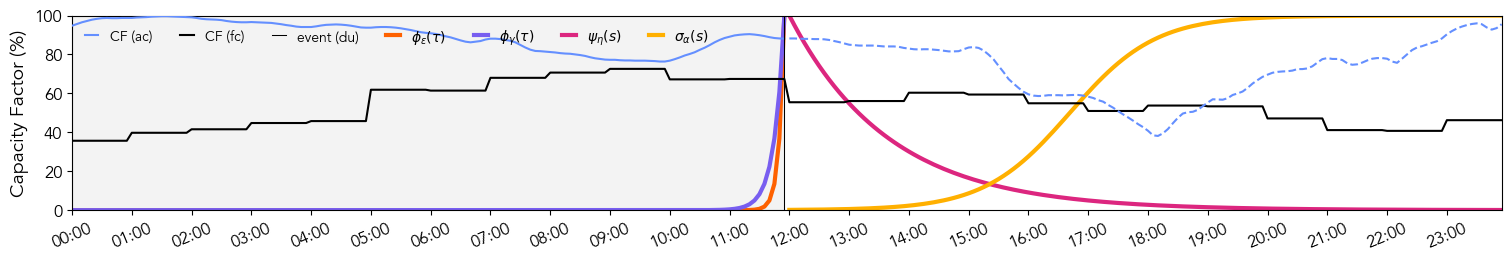

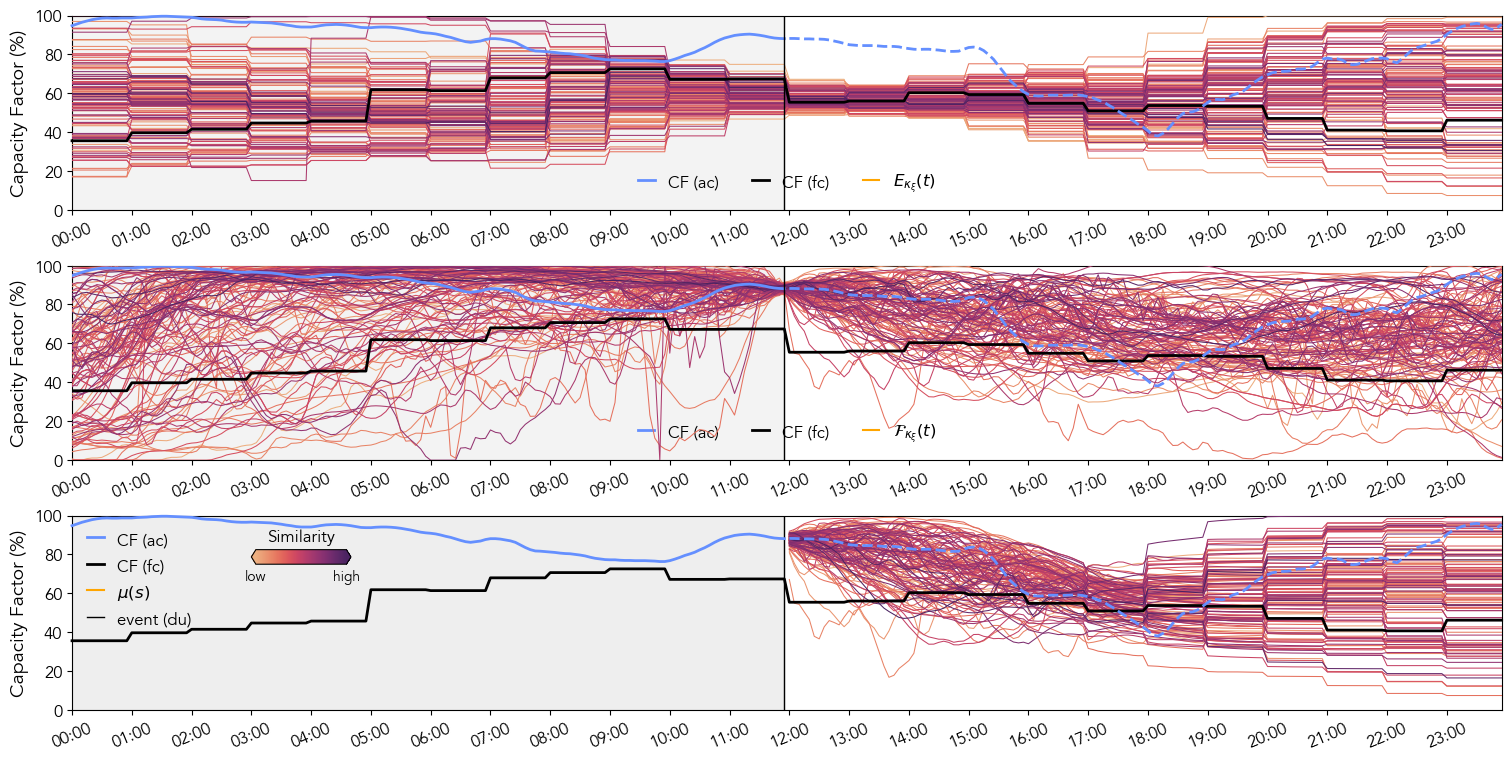

In [168]:
# d = 11 high day-ahead error
# d = 5 low day-ahead error
# When we do the max in the similarity, it should be min instead.
# sparsest: (array([ 33,  84,  89,  92, 148, 176, 249, 256]), array([7, 6, 8, 6, 8, 8, 8, 6]))
# densest 15683.0: (array([195]), array([4]))
# densest: 99
# sprasest: 4

a = 1
d = 9
t = 12 * 12
file_name = f"{a}-{d}-{t}"
print(file_name)

# Weighting functions parameters
forget_rate_f = 1.0
forget_rate_e = 0.5
lookup_rate = 0.05

# Distance parameters
length_scale_f = 0.1
length_scale_e = 0.75

# Scenario selection paramters
gamma = 0.2
xi = 0.99
kappa_min = 100
kappa_max = 250

f_ = F_ts_[d, :t, a]
f_hat_ = F_ts_[d, t:, a]
e_ = E_ts_[d, :, a]

# Get constants
T = E_ts_.shape[1]
tau_ = dt_[:t]
s_ = dt_[t:]

# phi: importance weights based on past time distance
phi_ = _exponential_growth(t, forget_rate_f)

# psi: importance weights based on past and future time distance
psi_1_ = _exponential_growth(t, forget_rate_e)
psi_2_ = _exponential_decay(t, lookup_rate)
psi_ = np.concatenate([psi_1_, psi_2_], axis=0)

# d: Euclidean distance between samples weighted by importance weights
d_f_ = _euclidian_dist(F_tr_[:, :t], f_, w_=phi_)
d_e_ = _euclidian_dist(E_tr_, e_, w_=psi_)
d_h_ = _haversine_dist(x_ts_[a, :], x_tr_)
d_p_ = _periodic_dist(t_tr_[d], t_tr_)
print(x_tr_.shape, x_ts_.shape, d_h_.shape)
print(t_tr_.shape, t_ts_.shape, d_p_.shape)

# w: normalized weights distance across observations based on the exponential link function
w_f_ = _kernel(d_f_, length_scale_f)
w_e_ = _kernel(d_e_, length_scale_e)
W_ = np.stack([w_f_, w_e_])

w_, idx_rank_, idx_bool_, idx_1_, idx_2_, xi, gamma, sigma, status = (
    _scenario_filtering(W_, d_h_, d_p_, xi, gamma, kappa_min, kappa_max)
)

# eta: importance weights based on future time distance
rmse = np.sqrt(np.mean((e_[:t] - f_) ** 2))
wrmse = np.sqrt(np.sum(psi_1_ * (e_[:t] - f_) ** 2) / psi_1_.sum())

nu         = t*5 + (24*12*5 - t*5)*rmse
trust_rate = np.exp(1. - rmse)/(1 + 200*rmse)
print(trust_rate)
print(rmse, wrmse, nu, t*5, ((24*12*5 - t*5)*rmse))

eta_ = _logistic(s_ - nu, k=trust_rate)

# Fuse scenarios with day-ahead forecasts
M_ = np.zeros((idx_2_.shape[0], eta_.shape[0]))
for i, j in zip(idx_2_, range(idx_2_.shape[0])):
    M_[j, :] = F_tr_[i, t:] * (1.0 - eta_) + E_tr_[i, t:] * eta_
print(M_.shape)


fig, _ax = plt.subplots(1, 1, figsize=(15, 2.5), layout="constrained")

_plot_forecast_parameters(_ax, f_, e_, f_hat_, phi_, psi_, eta_, dx_, dt_, t)

plt.show()

fig, _ax = plt.subplot_mosaic(
    [["a"], ["b"], ["c"]],
    figsize=(15, 7.5),
    layout="constrained",
)

_plot_forecasts(_ax["a"], F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

_plot_scenarios(_ax["b"], F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

_plot_updates(_ax["c"], F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

plt.show()


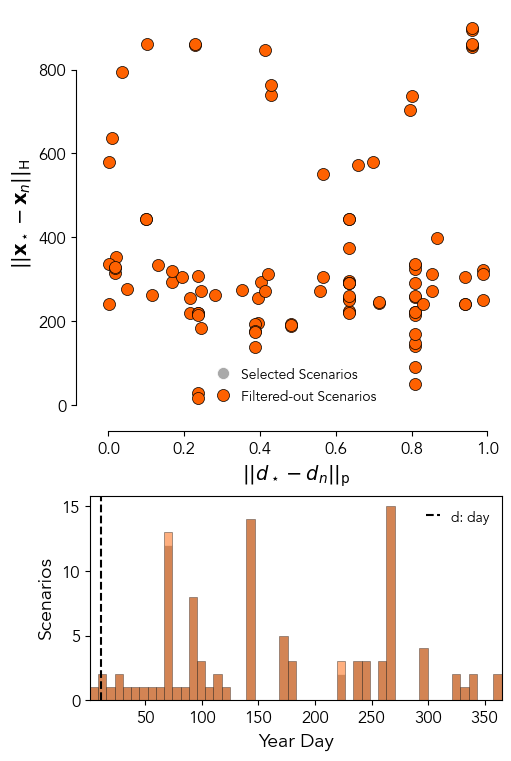

In [6]:
def _scenario_filtering(_ax, d_h_, d_p_, idx_1_, idx_2_, gamma, sigma):

    _ax.scatter(
        d_p_[idx_1_],
        d_h_[idx_1_],
        s=75,
        c="darkgray",
        lw=0.5,
        edgecolor="w",
        clip_on=False,
        zorder=4,
        label="Selected Scenarios",
    )
    _ax.scatter(
        d_p_[idx_2_],
        d_h_[idx_2_],
        s=75,
        c=palette_.loc[3, "ibm"],
        lw=0.5,
        edgecolor="k",
        clip_on=False,
        zorder=5,
        label="Filtered-out Scenarios",
    )

    if gamma != 0:
        _ax.axvline(gamma, c="k", lw=0.75, zorder=2, label="Thresholds")
    if sigma != 0:
        _ax.axhline(sigma, c="k", lw=0.75, zorder=2)

    _ax.set_ylabel(r"$|| \mathbf{x}_\star - \mathbf{x}_n ||_\mathrm{H}$", size=14)
    _ax.set_xlabel(r"$|| d_\star - d_n ||_\mathrm{p}$", size=14)

    _ax.tick_params(axis="both", labelsize=12)
    sns.despine(trim=True, offset=10, ax=_ax)

    _ax.legend(frameon=False, ncol=1)


def _dates_histogram(_ax, t_tr_, idx_1_, idx_2_):

    _ax.hist(
        t_tr_[idx_1_], bins=50, range=(1, 365), color="darkgray", edgecolor="w", lw=0.5
    )

    _ax.hist(
        t_tr_[idx_2_],
        bins=50,
        range=(1, 365),
        alpha=0.5,
        color=palette_.loc[3, "ibm"],
        edgecolor="k",
        lw=0.5,
    )
    _ax.axvline(d, c="k", ls="--", lw=1.5, zorder=2, label="d: day")
    _ax.set_xlabel(r"Year Day", size=14)
    _ax.set_ylabel(r"Scenarios", size=14)
    _ax.set_xlim(1, 365)
    _ax.tick_params(axis="both", labelsize=12)
    _ax.legend(frameon=False, ncol=1)


fig, _ax = plt.subplot_mosaic(
    [["a"], ["a"], ["b"]],
    figsize=(5, 7.5),
    layout="constrained",
)

_scenario_filtering(_ax["a"], d_h_, d_t_, idx_1_, idx_2_, gamma, sigma)
_dates_histogram(_ax["b"], t_tr_, idx_1_, idx_2_)

plt.savefig(path_to_images + r"/filtering.png", bbox_inches="tight", dpi=300)


plt.show()

# Visualization Utils

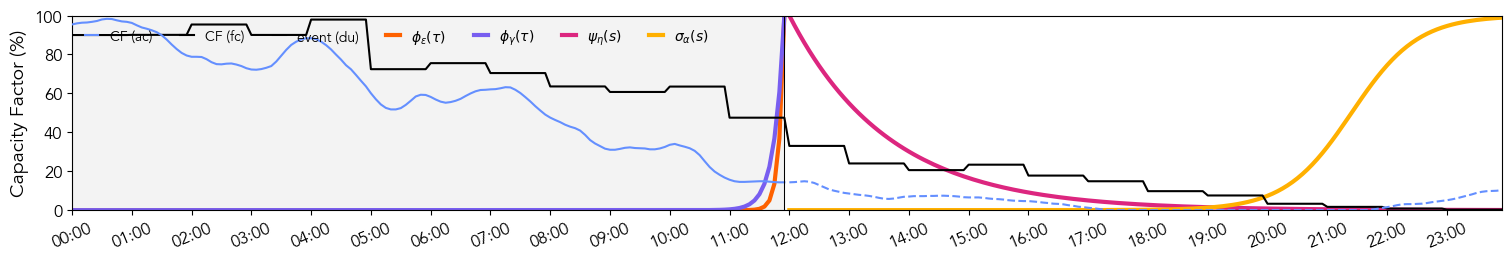

In [7]:
def _plot_forecast_parameters(_ax, f_, e_, f_hat_, phi_, psi_, eta_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    _ax.plot(
        tau_, 100.0 * f_, c=palette_.loc[0, "ibm"], label="CF (ac)", lw=1.5, zorder=5
    )

    _ax.plot(s_, 100.0 * f_hat_, c=palette_.loc[0, "ibm"], lw=1.5, ls="--", zorder=5)

    _ax.plot(dt_, 100.0 * e_, lw=1.5, label="CF (fc)", c="k", zorder=4)

    _ax.fill_between(
        tau_,
        100.0 * np.ones(tau_.shape),
        100.0 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.25,
        zorder=1,
    )

    _ax.axvline(dt_[t - 1], color="k", lw=0.75, label="event (du)", zorder=6)

    _ax.plot(
        tau_,
        100.0 * phi_,
        c=palette_.loc[3, "ibm"],
        lw=3,
        label=r"$\phi_{\varepsilon} (\tau)$",
        zorder=2,
    )

    _ax.plot(
        tau_,
        100.0 * psi_[:t],
        c=palette_.loc[1, "ibm"],
        lw=3,
        label=r"$\phi_{\gamma} (\tau)$",
        zorder=2,
    )

    _ax.plot(
        s_,
        100.0 * psi_[t:],
        c=palette_.loc[2, "ibm"],
        lw=3,
        label=r"$\psi_{\eta} (s)$",
        zorder=2,
    )

    _ax.plot(
        s_,
        100.0 * eta_,
        c=palette_.loc[4, "ibm"],
        lw=3,
        label=r"$\sigma_{\alpha} (s) $",
        zorder=2,
    )

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    _ax.tick_params(axis="both", labelsize=12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.legend(frameon=False, ncol=10, loc="upper left")


fig, _ax = plt.subplots(1, 1, figsize=(15, 2.5), layout="constrained")

_plot_forecast_parameters(_ax, f_, e_, f_hat_, phi_, psi_, eta_, dx_, dt_, t)

plt.savefig(path_to_images + r"/parameters.png", bbox_inches="tight", dpi=300)

plt.show()

99 Jan


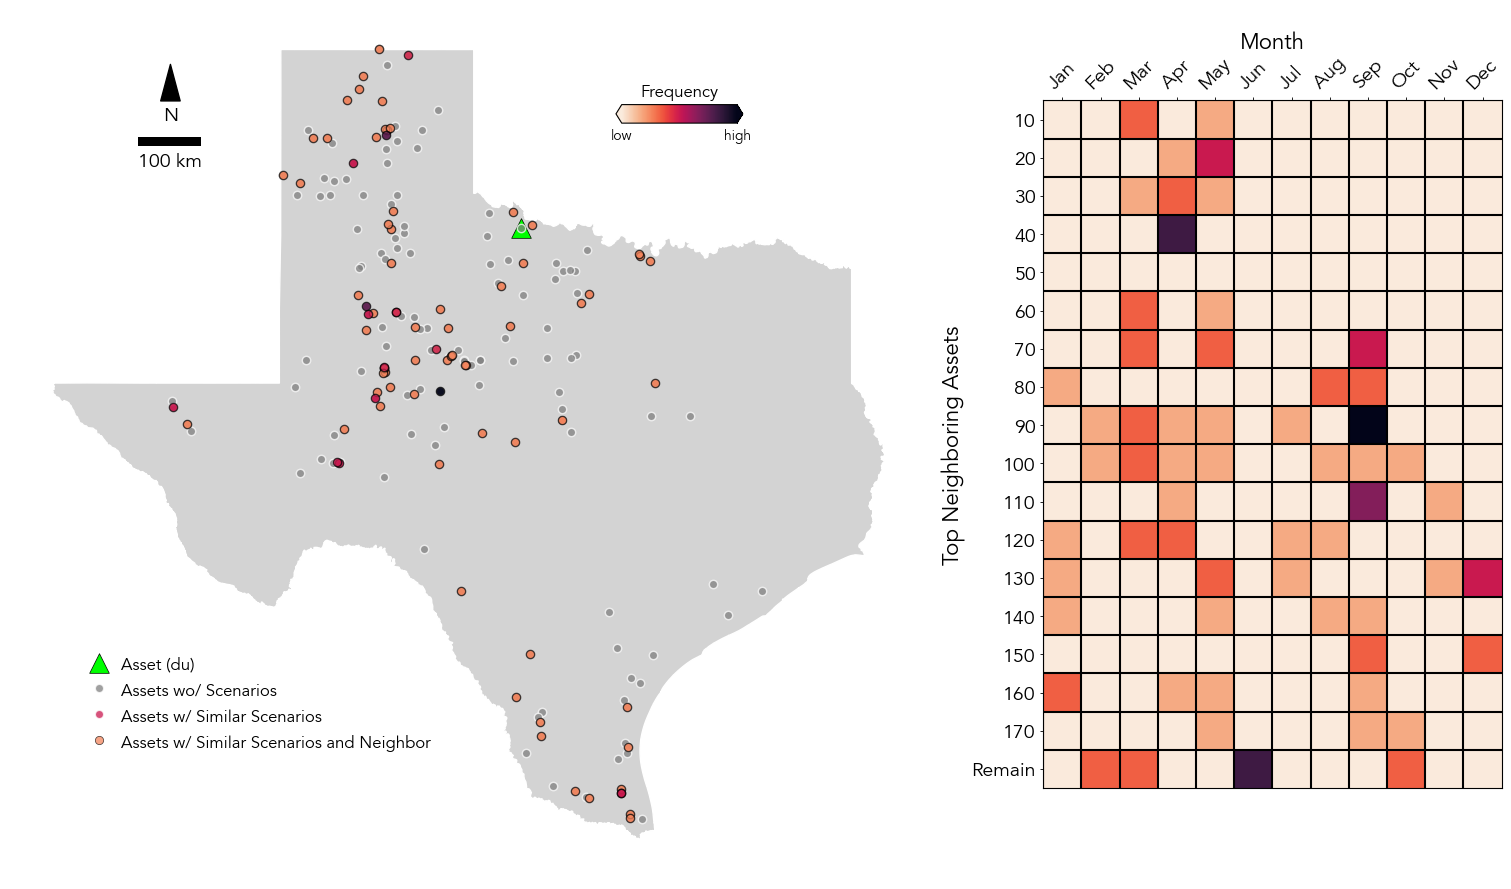

In [26]:
def _plot_frequency_map(_ax, x_tr_, x_ts_, x_, idx_0_, idx_1_, idx_2_):

    x_tr_p_, z_tr_p_ = np.unique(x_tr_[idx_1_, :], return_counts=True, axis=0)
    x_tr_pp_, z_tr_pp_ = np.unique(x_tr_[idx_2_, :], return_counts=True, axis=0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _norm = plt.Normalize(0.0, z_tr_p_.max())

    TX_.plot(ax=_ax, facecolor="lightgray", edgecolor="white", zorder=0)

    _ax.scatter(
        x_[0],
        x_[1],
        c="lime",
        lw=0.5,
        ec="k",
        s=200.0,
        zorder=1,
        marker="^",
        label="Asset (du)",
    )

    _ax.plot(
        x_ts_[:, 0],
        x_ts_[:, 1],
        c="gray",
        alpha=0.75,
        ms=6,
        marker="o",
        mec="w",
        ls="none",
        mew=1.0,
        zorder=2,
        label="Assets wo/ Scenarios",
    )

    _ax.plot(
        x_tr_[idx_1_[0], 0],
        x_tr_[idx_1_[0], 1],
        c=_cmap(_norm(z_tr_p_.max() / 2.0)),
        alpha=0.75,
        ms=6,
        ls="none",
        marker="o",
        mec="w",
        mew=1.0,
        zorder=3,
        label="Assets w/ Similar Scenarios",
    )

    _ax.plot(
        x_tr_[idx_2_[0], 0],
        x_tr_[idx_2_[0], 1],
        c=_cmap(_norm(z_tr_p_.max() / 4.0)),
        alpha=0.75,
        ms=6,
        ls="none",
        marker="o",
        mec="k",
        mew=0.5,
        zorder=3,
        label="Assets w/ Similar Scenarios and Neighbor",
    )

    for i in np.arange(x_tr_p_.shape[0], dtype=int)[np.argsort(z_tr_p_)]:
        _ax.plot(
            x_tr_p_[i, 0],
            x_tr_p_[i, 1],
            c=_cmap(_norm(z_tr_p_[i])),
            alpha=0.75,
            ms=6,
            ls="none",
            marker="o",
            mec="w",
            mew=1.0,
            zorder=4,
        )

    for i in np.arange(x_tr_pp_.shape[0], dtype=int)[np.argsort(z_tr_pp_)]:
        _ax.plot(
            x_tr_pp_[i, 0],
            x_tr_pp_[i, 1],
            c=_cmap(_norm(z_tr_pp_[i])),
            alpha=0.75,
            ms=6,
            ls="none",
            marker="o",
            mec="k",
            mew=1.0,
            zorder=5,
        )

    cbar = fig.colorbar(
        cm.ScalarMappable(cmap=_cmap),
        cax=_ax.inset_axes([-97.75, 35.5, 2.0, 0.25], transform=_ax.transData),
        orientation="horizontal",
        extend="both",
    )

    cbar.set_ticks([0, 1], labels=["low", "high"])
    cbar.ax.tick_params(length=0)
    cbar.ax.set_title("Frequency", rotation=0, fontsize=12)

    _ax.legend(
        frameon=False,
        # loc     = 'upper left',
        bbox_to_anchor=(0.475, 0.275),
        ncol=1,
        fontsize=12,
    )

    # Add compass (North arrow)
    x, y, arrow_length = 0.175, 0.94, 0.0625  # relative axes coords
    _ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - arrow_length),
        arrowprops=dict(
            facecolor="k", arrowstyle="wedge,tail_width=1,shrink_factor=.5"
        ),
        ha="center",
        va="center",
        fontsize=14,
        xycoords=_ax.transAxes,
    )

    scalebar = ScaleBar(
        dx=100,  # scaling factor
        units="km",
        dimension="si-length",  # could also be 'imperial-length'
        location="upper left",
        length_fraction=0.075,  # fraction of the axis for bar length
        color="black",
        box_color="None",
        box_alpha=1.0,
        border_pad=9,
        font_properties={"size": 14},
    )

    _ax.add_artist(scalebar)

    _ax.set_axis_off()


def _selected_scenarios_heatmap(_ax, T_tr_, T_ts_, x_ts_, idx_1_, idx_2_):

    N = 17
    delta = 10

    d_ = _haversine_dist(x_ts_[a, :], x_ts_)
    d_sort_ = np.sort(d_)

    tops_ = [int((i + 1) * delta) for i in range(N)]
    intervals_ = [d_sort_[i] for i in tops_]

    m_a = datetime.datetime.strptime(T_ts_[d], "%Y-%m-%d").timetuple().tm_mon - 1
    m_tr_ = np.stack(
        [
            datetime.datetime.strptime(T_tr_[i], "%Y-%m-%d").timetuple().tm_mon - 1
            for i in range(T_tr_.shape[0])
        ]
    )

    K = 0
    heatmap_ = np.zeros((N + 1, m_tr_.max() + 1))
    for d_s, m in zip(d_s_[idx_1_], m_tr_[idx_1_]):
        heatmap_[np.searchsorted(intervals_, d_s), m] += 1
        K += 1

    _cmap = sns.color_palette("rocket_r", as_cmap=True)

    month_ = [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]

    print(K, month_[m_a])

    _ax.matshow(heatmap_, cmap=_cmap, vmin=0.0, extent=[0, 12, N + 1, 0])

    _ax.set_xticks(range(len(month_)), [] * len(month_))
    _ax.set_yticks(range(len(tops_) + 1), [] * (len(tops_) + 1))

    _ax.set_ylabel("Top Neighboring Assets", size=16)
    _ax.set_xlabel("Month", size=16)
    _ax.xaxis.set_label_position("top")

    _ax.set_xticks(
        np.arange(len(month_), dtype=int) + 0.5,
        month_,
        rotation=45,
        minor=True,
        size=14,
    )

    _ax.set_yticks(
        np.arange(len(tops_) + 1, dtype=int) + 0.5,
        tops_ + ["Remain"],
        minor=True,
        size=14,
    )

    _ax.tick_params(which="major", bottom=False, left=False, top=False)

    _ax.tick_params(which="minor", bottom=False)

    _ax.grid(which="major", color="k", linestyle="-", linewidth=1.5)


#     cbar = fig.colorbar(cm.ScalarMappable(cmap = _cmap),
#                         cax = ax.inset_axes([3.5, 19, 5., .5], transform = ax.transData),
#                         orientation = 'horizontal',
#                         extend      = 'both')

#     cbar.set_ticks([0, 1], labels = ['low', 'high'], size = 12)
#     cbar.ax.tick_params(length = 0)
#     cbar.ax.set_title('Frequency', rotation = 0, size = 14)


fig, _ax = plt.subplot_mosaic(
    [["a", "b"]],
    figsize=(15, 15),
    layout="constrained",
    gridspec_kw=dict(width_ratios=(2, 1)),
)


_plot_frequency_map(_ax["a"], x_tr_, x_ts_, x_ts_[a, :], idx_bool_, idx_1_, idx_2_)
_selected_scenarios_heatmap(_ax["b"], T_tr_, T_ts_, x_ts_, idx_1_, idx_2_)

plt.savefig(path_to_images + r"/frequency_heatmap.png", bbox_inches="tight", dpi=300)

plt.show()

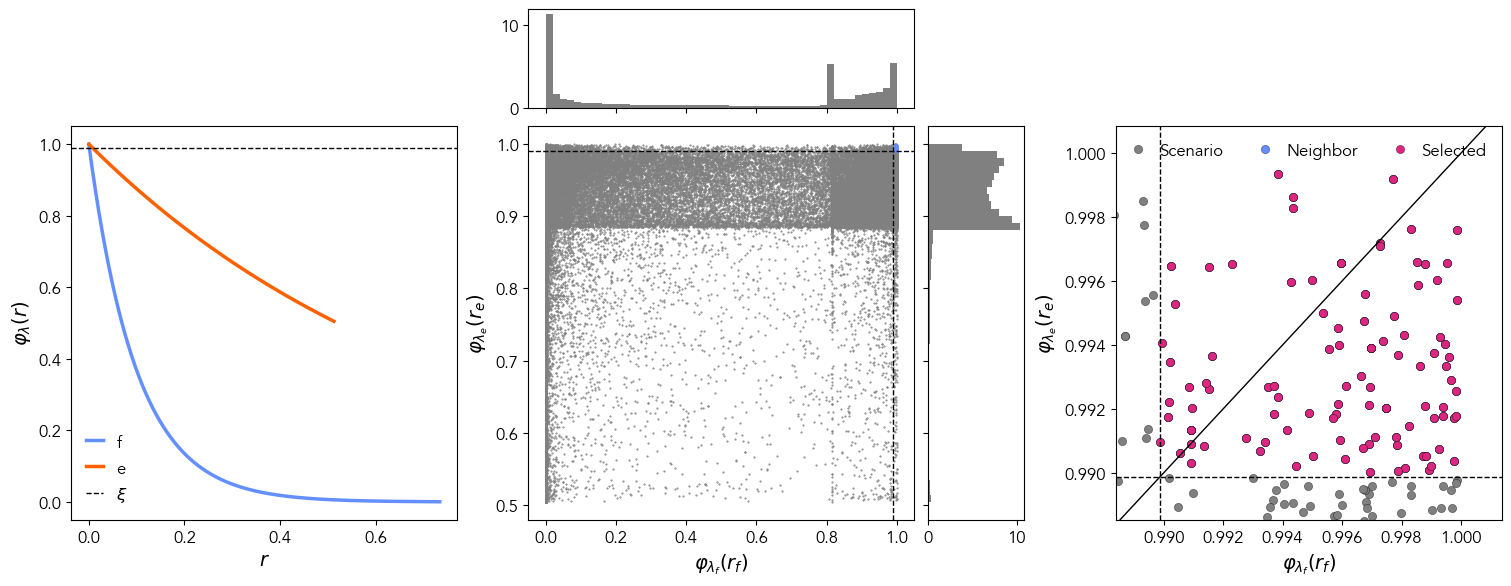

In [39]:
def _fneighborhood(_ax, d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

    _ax["a"].plot(
        d_f_[np.argsort(d_f_)],
        w_f_[np.argsort(d_f_)],
        c=palette_.loc[0, "ibm"],
        lw=2.5,
        label="f",
    )

    _ax["a"].plot(
        d_e_[np.argsort(d_e_)],
        w_e_[np.argsort(d_e_)],
        c=palette_.loc[3, "ibm"],
        lw=2.5,
        label="e",
    )

    _ax["a"].axhline(xi, ls="--", color="k", lw=1.0, label=r"$\xi$", zorder=10)
    _ax["a"].set_ylabel(r"$\varphi_{\lambda} (r)$", size=14)
    _ax["a"].set_xlabel(r"$r$", size=14)
    _ax["a"].tick_params(axis="both", labelsize=12)
    _ax["a"].legend(frameon=False, fontsize=12)

    _ax["e"].scatter(
        w_f_, w_e_, c="gray", s=35, alpha=1.0, lw=0.25, ec="k", label="Scenario"
    )

    _ax["e"].scatter(
        w_f_[idx_1_],
        w_e_[idx_1_],
        c=palette_.loc[0, "ibm"],
        s=35,
        alpha=1.0,
        lw=0.25,
        ec="k",
        label="Neighbor",
    )

    c_ = [palette_.loc[2, "ibm"], palette_.loc[4, "ibm"]]
    # for i, j in zip(idx_2_, idx_0_[idx_2_]):
    _ax["e"].scatter(
        w_f_[idx_2_],
        w_e_[idx_2_],
        c=palette_.loc[2, "ibm"],
        s=35,
        lw=0.25,
        ec="k",
        alpha=1.0,
        label="Selected",
    )

    _ax["e"].axline((1, 1), slope=1, lw=1, c="k")
    _ax["e"].set_ylabel(r"$\varphi_{\lambda_e} (r_{e})$", size=14)
    _ax["e"].set_xlabel(r"$\varphi_{\lambda_f} (r_{f})$", size=14)
    _ax["e"].tick_params(axis="both", labelsize=12)
    _ax["e"].set_xlim(w_f_[idx_2_].min() * 0.9985, w_f_[idx_2_].max() * 1.0015)
    _ax["e"].set_ylim(w_e_[idx_2_].min() * 0.9985, w_e_[idx_2_].max() * 1.0015)

    _ax["e"].axhline(xi, ls="--", color="k", lw=1.0, zorder=10)

    _ax["e"].axvline(xi, ls="--", color="k", lw=1.0, zorder=10)

    _ax["e"].legend(frameon=False, fontsize=12, ncol=3)

    _ax["c"].tick_params(axis="x", labelbottom=False)
    _ax["d"].tick_params(axis="y", labelleft=False)

    _ax["b"].scatter(w_f_, w_e_, color="gray", s=0.25, zorder=1)

    _ax["b"].scatter(
        w_f_[idx_1_], w_e_[idx_1_], c=palette_.loc[0, "ibm"], s=0.25, zorder=2
    )

    _ax["b"].axhline(xi, ls="--", color="k", lw=1.0, label=r"$\xi$", zorder=10)

    _ax["b"].axvline(xi, ls="--", color="k", lw=1.0, label=r"$\xi$", zorder=10)

    _ax["b"].set_ylabel(r"$\varphi_{\lambda_e} (r_{e})$", size=14)
    _ax["b"].set_xlabel(r"$\varphi_{\lambda_f} (r_{f})$", size=14)
    _ax["b"].tick_params(axis="both", labelsize=12)

    _ax["c"].hist(w_f_, bins=50, color="gray", density=True)

    _ax["c"].tick_params(axis="both", labelsize=12)

    _ax["d"].hist(w_e_, bins=50, color="gray", density=True, orientation="horizontal")

    _ax["d"].tick_params(axis="both", labelsize=12)

fig, _ax = plt.subplot_mosaic(
    [
        [".", ".", "c", ".", ".", "."],
        ["a", "a", "b", "d", "e", "e"],
        ["a", "a", "b", "d", "e", "e"],
    ],
    figsize=(15, 5.75),
    layout="constrained",
    gridspec_kw=dict(width_ratios=(2, 2, 4, 1, 2, 2), height_ratios=(1, 2, 2)),
)

_fneighborhood(_ax, d_f_, d_e_, w_f_, w_e_, w_, idx_bool_, idx_1_, idx_2_, xi)

plt.savefig(path_to_images + r"/fneighbor.png", bbox_inches="tight", dpi=300)

plt.show()

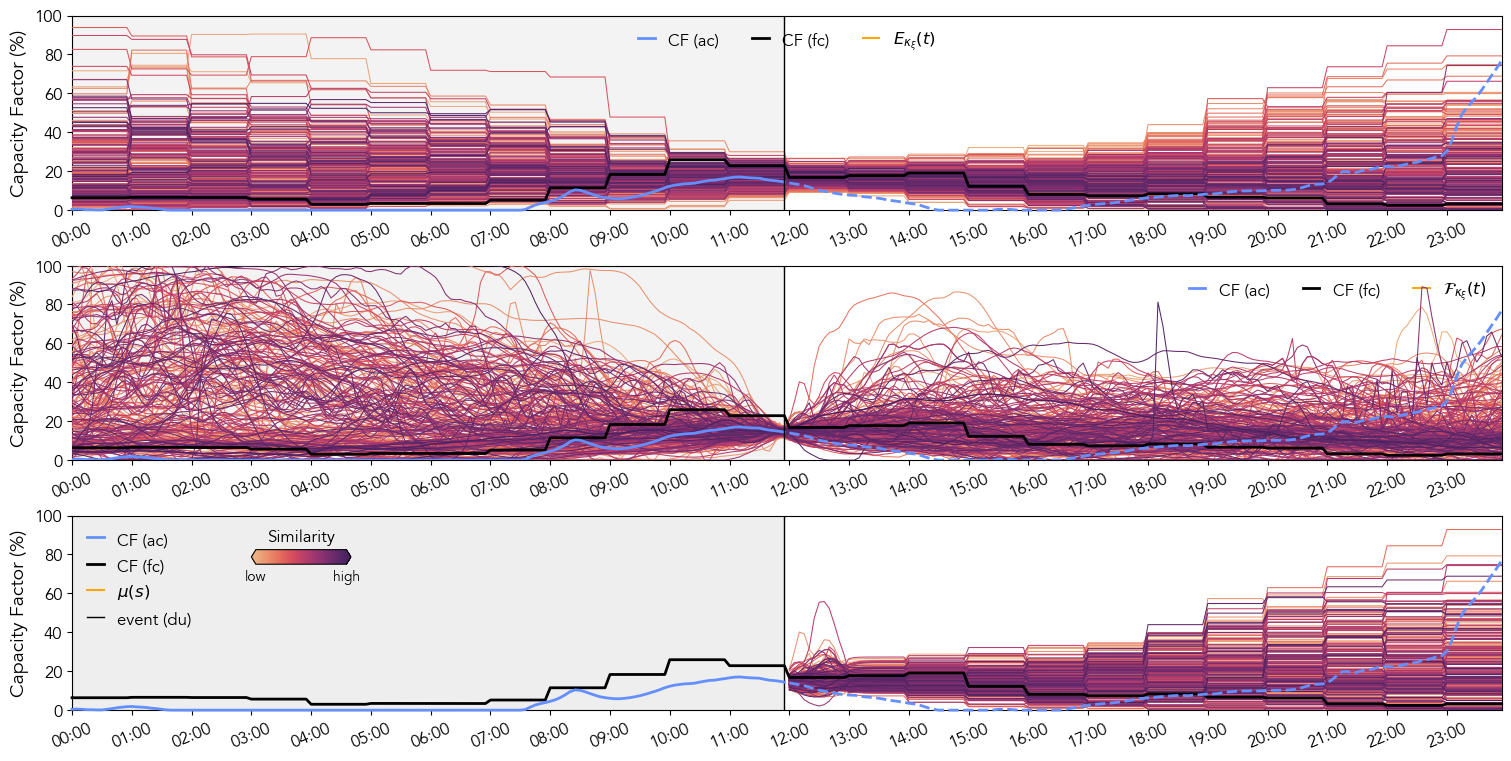

In [157]:
def _plot_forecasts(_ax, F_tr_, E_tr_, M_, f_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    z_ = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]
    _cmap = sns.color_palette("flare", as_cmap=True)
    _norm = plt.Normalize(z_[idx_].min(), z_[idx_].max())

    _ax.plot(
        tau_,
        100.0 * f_,
        c=palette_.loc[0, "ibm"],
        clip_on=False,
        zorder=10,
        label="CF (ac)",
        lw=2,
    )

    _ax.plot(
        s_,
        100.0 * f_hat_,
        c=palette_.loc[0, "ibm"],
        clip_on=False,
        zorder=10,
        lw=2,
        ls="--",
    )

    _ax.plot(dt_, 100.0 * e_, clip_on=False, lw=2, zorder=9, label="CF (fc)", c="k")

    _ax.plot([], [], label=r"$E_{\kappa_{\xi}}(t)$", c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_, 100 * E_tr_[i, :], c=_cmap(_norm(z_[i])), lw=0.75, zorder=8)

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.25,
        zorder=1,
    )

    _ax.axvline(dt_[t - 1], color="k", lw=1.0, zorder=11)

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)

    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=12)

    _ax.legend(frameon=False, fontsize=12, ncol=10)


def _plot_scenarios(_ax, F_tr_, E_tr_, M_, f_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    z_ = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]
    _cmap = sns.color_palette("flare", as_cmap=True)
    _norm = plt.Normalize(z_[idx_].min(), z_[idx_].max())

    _ax.plot(
        tau_, 100.0 * f_, c=palette_.loc[0, "ibm"], zorder=10, label="CF (ac)", lw=2
    )

    _ax.plot(s_, 100.0 * f_hat_, c=palette_.loc[0, "ibm"], zorder=10, lw=2, ls="--")

    _ax.plot(dt_, 100.0 * e_, lw=2, zorder=9, label="CF (fc)", c="k")

    _ax.plot([], [], label=r"$\mathcal{F}_{\kappa_{\xi}}(t)$", c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_, 100 * F_tr_[i, :], c=_cmap(_norm(z_[i])), lw=0.75, zorder=8)

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.25,
        zorder=1,
    )

    _ax.axvline(dt_[t - 1], color="k", lw=1.0, zorder=11)

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=12)

    _ax.legend(frameon=False, fontsize=12, ncol=10)


def _plot_updates(_ax, F_tr_, E_tr_, M_, f_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    z_ = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]
    _cmap = sns.color_palette("flare", as_cmap=True)
    _norm = plt.Normalize(z_[idx_].min(), z_[idx_].max())

    _ax.plot(
        tau_,
        100.0 * f_,
        c=palette_.loc[0, "ibm"],
        zorder=10,
        label="CF (ac)",
        clip_on=False,
        lw=2,
    )

    _ax.plot(
        s_,
        100.0 * f_hat_,
        c=palette_.loc[0, "ibm"],
        zorder=10,
        lw=2,
        clip_on=False,
        ls="--",
    )

    _ax.plot(dt_, 100.0 * e_, lw=2, zorder=9, label="CF (fc)", clip_on=False, c="k")

    _ax.plot([], [], label=r"$\mu(s)$", c="orange")

    for i, j in zip(idx_, range(M_.shape[0])):
        _ax.plot(dt_[t:], 100 * M_[j, :], c=_cmap(_norm(z_[i])), lw=0.75, zorder=8)

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.375,
        zorder=1,
    )

    _ax.axvline(dt_[t - 1], color="k", lw=1.0, label="event (du)", zorder=8)
    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    _ax.tick_params(axis="both", labelsize=12)
    _ax.legend(frameon=False, fontsize=12, ncol=1)

    cbar = fig.colorbar(
        cm.ScalarMappable(_norm, _cmap),
        cax=_ax.inset_axes([180, 75, 100, 7.5], transform=_ax.transData),
        orientation="horizontal",
        extend="both",
    )

    cbar.set_ticks([0, 1], labels=["low", "high"])
    cbar.ax.tick_params(length=0)
    cbar.ax.set_title("Similarity", rotation=0)


fig, _ax = plt.subplot_mosaic(
    [["a"], ["b"], ["c"]],
    figsize=(15, 7.5),
    layout="constrained",
)

_plot_forecasts(_ax["a"], F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

_plot_scenarios(_ax["b"], F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

_plot_updates(_ax["c"], F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

plt.savefig(path_to_images + r"/scenarios_fc.png", bbox_inches="tight", dpi=300)

plt.show()

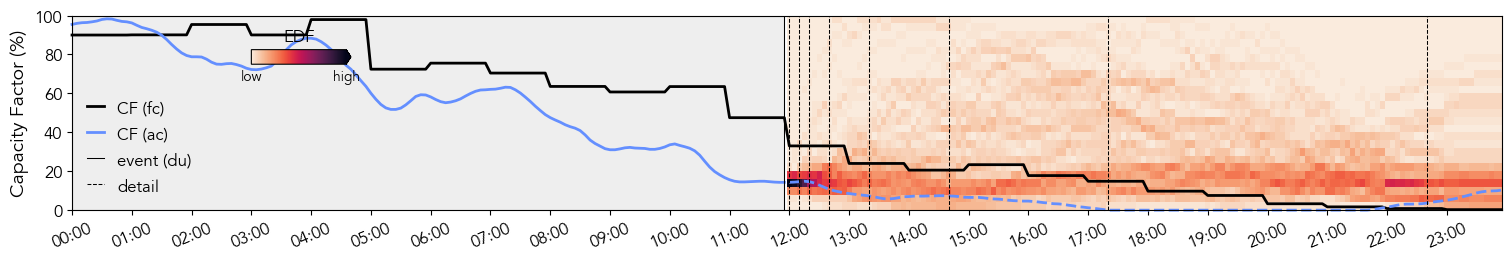

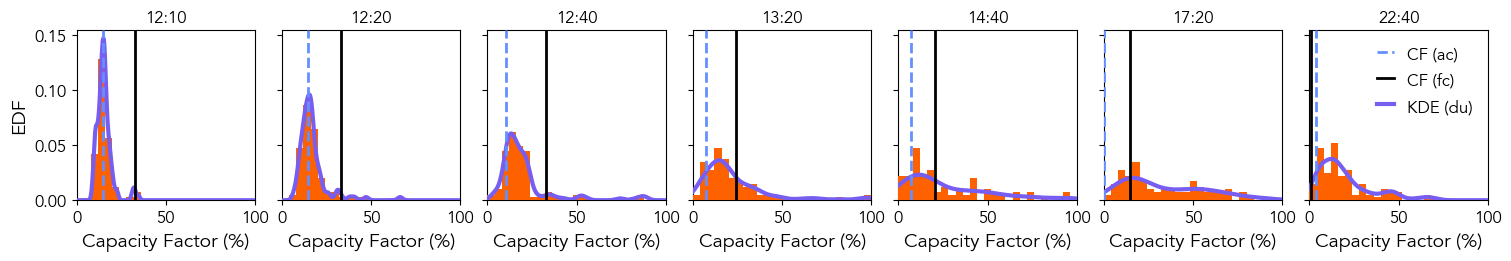

In [30]:
def _plot_histogram_cuts(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    x_ = np.linspace(0, 100, 1000)[:, np.newaxis]

    for cut, i in zip(cuts_, range(len(cuts_))):
        _KD = KernelDensity(
            bandwidth=_silverman_rule(100 * M_[:, cut]),
            algorithm="auto",
            kernel="gaussian",
        ).fit(100 * M_[:, cut][:, np.newaxis])

        _ax[i].axvline(
            100.0 * f_hat_[cut],
            color=palette_.loc[0, "ibm"],
            lw=2,
            ls="--",
            label="CF (ac)",
            zorder=10,
        )

        _ax[i].axvline(100.0 * e_[t + cut], color="k", lw=2, label="CF (fc)", zorder=10)

        _ax[i].hist(
            100.0 * M_[:, cut],
            bins=25,
            range=(0, 100),
            density=True,
            color=palette_.loc[3, "ibm"],
            zorder=8,
        )

        _ax[i].plot(
            x_,
            np.exp(_KD.score_samples(x_)),
            label="KDE (du)",
            color=palette_.loc[1, "ibm"],
            lw=3,
            zorder=9,
        )

        _ax[i].set_title(dx_[t:][cut])
        _ax[i].set_xlim(0, 100)
        _ax[i].set_ylim(
            0,
        )
        _ax[i].set_xlabel("Capacity Factor (%)", size=14)
        _ax[i].tick_params(axis="both", labelsize=12)

    _ax[0].set_ylabel("EDF", size=14)

    _ax[-1].legend(frameon=False, fontsize=12)


def _plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    Z_ = []
    for i in range(M_.shape[1]):
        a_, b_ = np.histogram(100.0 * M_[:, i], bins=25, range=(0, 100), density=True)
        Z_.append(a_)

    Z_ = np.stack(Z_).T
    X_, Y_ = np.meshgrid(dt_[t:], (b_[1:] + b_[:-1]) / 2.0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _ax.pcolormesh(X_, Y_, Z_, cmap=_cmap)

    _ax.plot(dt_, 100.0 * e_, c="k", lw=2.0, label="CF (fc)", clip_on=False)

    _ax.plot(
        tau_,
        100.0 * f_,
        c=palette_.loc[0, "ibm"],
        clip_on=False,
        lw=2.0,
        label="CF (ac)",
    )

    _ax.plot(
        s_, 100.0 * f_hat_, c=palette_.loc[0, "ibm"], clip_on=False, lw=2.0, ls="--"
    )

    _ax.fill_between(
        tau_,
        100.0 * np.ones(tau_.shape),
        100.0 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.375,
    )

    _ax.axvline(dt_[t - 1], color="k", linewidth=0.75, label="event (du)")

    _ax.axvline(dt_[t], color="k", lw=0.75, ls="--", label="detail")

    for cut in cuts_:
        _ax.axvline(dt_[t + cut], color="k", lw=0.75, ls="--")

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=12)

    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])

    _ax.legend(frameon=False, fontsize=12, ncol=1)

    cbar = fig.colorbar(
        cm.ScalarMappable(cmap=_cmap),
        cax=_ax.inset_axes([180, 75, 100, 7.5], transform=_ax.transData),
        orientation="horizontal",
        extend="max",
    )

    cbar.set_ticks([0, 1], labels=["low", "high"])
    cbar.ax.tick_params(length=0)

    cbar.ax.set_title("EDF", rotation=0)


cuts_ = [2, 4, 8, 16, 32, 64, 128]

fig, _ax = plt.subplots(1, 1, figsize=(15, 2.5), layout="constrained")

_plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_)

plt.savefig(path_to_images + r"/eCDF_heatmap.pdf", bbox_inches="tight", dpi=300)

plt.show()

fig, _ax = plt.subplots(
    1, len(cuts_), figsize=(15, 2.5), sharey=True, layout="constrained"
)

_plot_histogram_cuts(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_)

plt.savefig(path_to_images + r"/hist_cutoffs.pdf", bbox_inches="tight", dpi=300)

plt.show()

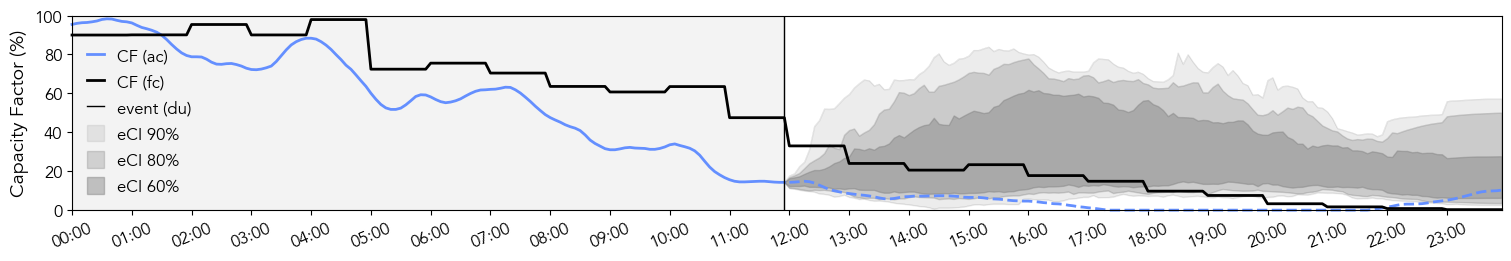

In [31]:
def _eQuantile(_eCDF, q_):
    """
    Calculates quantiles from an ECDF.

    Args:
    _eCDF: function from statsmodels api
    q_: A list or numpy array of quantiles to calculate (values between 0 and 1).

    Returns:
    _Q: A dictionary where keys are the input quantiles and values are the corresponding
    quantile values from the ECDF.
    """

    return np.array([_eCDF.x[np.searchsorted(_eCDF.y, q)] for q in q_])


def _plot_eQuantiles(_ax, Q_p_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_):

    _ax.plot(
        tau_, 100 * f_, c=palette_.loc[0, "ibm"], label="CF (ac)", lw=2.0, clip_on=False
    )

    _ax.plot(s_, 100 * f_hat_, c=palette_.loc[0, "ibm"], ls="--", lw=2.0, clip_on=False)

    _ax.plot(dt_, 100.0 * e_, c="k", lw=2.0, label="CF (fc)", clip_on=False)

    _ax.axvline(dt_[t - 1], color="k", lw=1.0, label="event (du)")

    for i in range(int(len(q_) / 2)):
        _ax.plot(s_p_, 100 * Q_p_[:, i], lw=0.125, c="lightgray", zorder=1)

        _ax.plot(s_p_, 100 * Q_p_[:, -i - 1], lw=0.125, c="lightgray", zorder=1)

        _ax.fill_between(
            s_p_,
            100 * Q_p_[:, i],
            100 * Q_p_[:, -i - 1],
            color="gray",
            alpha=0.15 + i * 0.15,
            label=f"eCI {q_label_[i]}",
            zorder=1,
        )

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.25,
    )

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    _ax.tick_params(axis="both", labelsize=12)
    _ax.legend(frameon=False, fontsize=12, ncol=1)
    # plt.grid(axis = 'y', linestyle = ':', lw = 1., zorder = 10)


# Extend quantiles to dynamic update event
M_p_ = np.concatenate([f_[-1] * np.ones((M_.shape[0], 1)), M_], axis=1)
s_p_ = np.concatenate([tau_[-1] * np.ones((1,)), s_], axis=0)

# Calculate quantiles from empirical distribution
q_ = [0.05, 0.1, 0.2, 0.8, 0.9, 0.95]
q_label_ = ["90%", "80%", "60%"]

Q_p_ = np.stack([_eQuantile(ECDF(M_p_[:, i]), q_) for i in range(M_p_.shape[1])])

fig, _ax = plt.subplots(1, 1, figsize=(15, 2.5), layout="constrained")

_plot_eQuantiles(_ax, Q_p_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_)

plt.savefig(path_to_images + r"/eCI.pdf", bbox_inches="tight", dpi=600)

plt.show()

(101, 3)


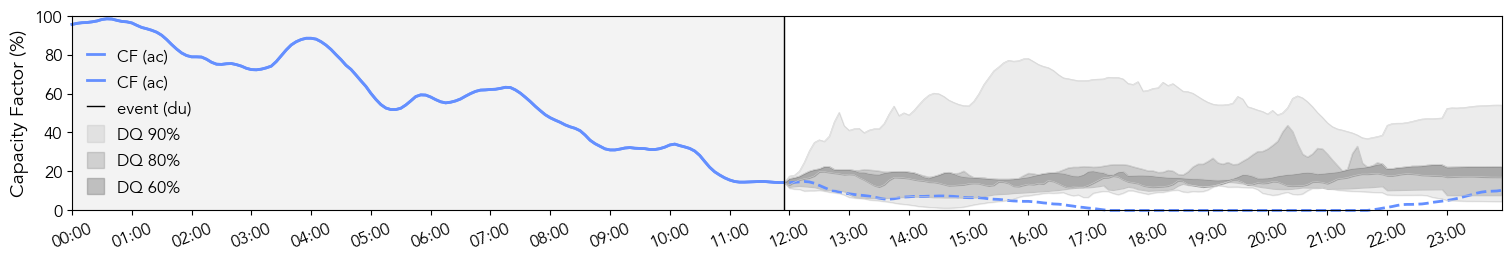

In [35]:
def _plot_fQuantiles(_ax, DQ_, M_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_):


    _ax.plot(
        tau_, 100 * f_, c=palette_.loc[0, "ibm"], label="CF (ac)", lw=2.0, clip_on=False
    )

    _ax.plot(
        tau_,
        100.0 * f_,
        c=palette_.loc[0, "ibm"],
        label="CF (ac)",
        lw=2.0,
        clip_on=False,
    )

    _ax.plot(
        s_, 100.0 * f_hat_, c=palette_.loc[0, "ibm"], ls="--", lw=2.0, clip_on=False
    )

    _ax.axvline(dt_[t - 1], color="k", linewidth=1.0, label="event (du)", zorder=10)

    for i in range(DQ_.shape[1]):

        m_ = 100.0 * M_[DQ_[:, i] <= 1.0]

        _ax.plot(s_p_, np.max(m_, axis=0), lw=0.375, c="lightgray")

        _ax.plot(s_p_, np.min(m_, axis=0), lw=0.375, c="lightgray")

        _ax.fill_between(
            s_p_,
            np.max(m_, axis=0),
            np.min(m_, axis=0),
            color="gray",
            alpha=0.15 + i * 0.15,
            label=f"DQ {q_label_[i]}",
            zorder=1,
        )

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.25,
    )

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.)
    _ax.legend(
        frameon=False,
        fontsize=12,
        # loc     = 'upper left',
        ncol=1,
    )
    _ax.tick_params(axis="both", labelsize=12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    # plt.grid(axis = 'y', linestyle = ':', lw = 1., zorder = 10)

# Extend quantiles to a dynamic update event
M_p_ = np.concatenate([f_[-1] * np.ones((M_.shape[0], 1)), M_], axis=1)
s_p_ = np.concatenate([tau_[-1] * np.ones((1,)), s_], axis=0)

# Calculate functional Directional Quantiles (DQ)
DQ_ = _fQuantile(M_, path_to_fDepth)
DQ_ = DQ_.to_numpy()[:, ::-1]
print(DQ_.shape)

fig, _ax = plt.subplots(1, 1, figsize=(15, 2.5), layout="constrained")

_plot_fQuantiles(_ax, DQ_, M_p_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_)

plt.savefig(path_to_images + r"/DQ.pdf", bbox_inches="tight", dpi=600)

plt.show()

Does not exist


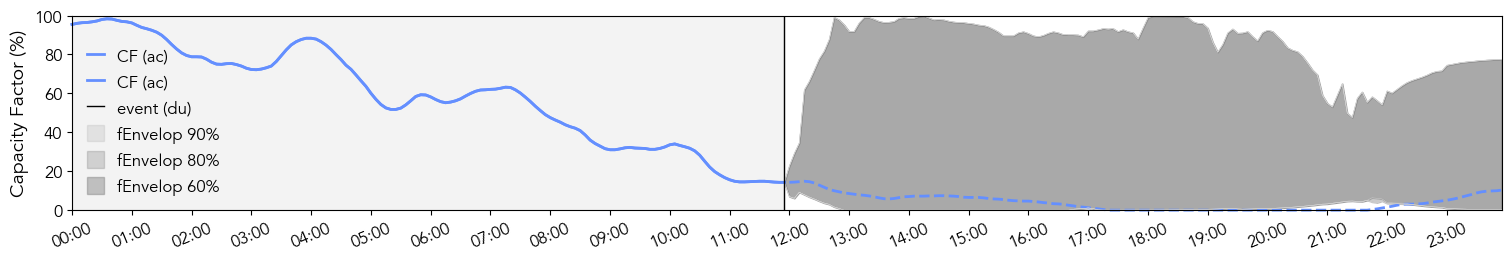

In [38]:
def _plot_fEnvelop(_ax, I_, M_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_):

    _ax.plot(
        tau_, 100 * f_, c=palette_.loc[0, "ibm"], label="CF (ac)", lw=2.0, clip_on=False
    )

    _ax.plot(
        tau_,
        100.0 * f_,
        c=palette_.loc[0, "ibm"],
        label="CF (ac)",
        lw=2.0,
        clip_on=False,
    )

    _ax.plot(
        s_, 100.0 * f_hat_, c=palette_.loc[0, "ibm"], ls="--", lw=2.0, clip_on=False
    )

    _ax.axvline(dt_[t - 1], color="k", linewidth=1.0, label="event (du)", zorder=10)

    for i in range(len(q_)):
        m_ = 100.0 * M_[I_[int(M_.shape[0] * q_[i]) :],]

        _ax.plot(s_p_, np.max(m_, axis=0), lw=0.375, c="lightgray")

        _ax.plot(s_p_, np.min(m_, axis=0), lw=0.375, c="lightgray")

        _ax.fill_between(
            s_p_,
            np.max(m_, axis=0),
            np.min(m_, axis=0),
            color="gray",
            alpha=0.15 + i * 0.15,
            label=f"fEnvelop {q_label_[i]}",
            zorder=1,
        )

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.25,
    )

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    _ax.legend(
        frameon=False,
        fontsize=12,
        # loc      = 'upper left',
        ncol=1,
    )
    _ax.tick_params(axis="both", labelsize=12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    # plt.grid(axis = 'y', linestyle = ':', lw = 1., zorder = 10)

# Extend quantiles to a dynamic update event
M_p_ = np.concatenate([f_[-1] * np.ones((M_.shape[0], 1)), M_], axis=1)
s_p_ = np.concatenate([tau_[-1] * np.ones((1,)), s_], axis=0)

# Calculate quantiles from empirical distribution
q_label_ = ["90%", "80%", "60%"]
q_ = [0.1, 0.2, 0.4]

# Functional depth
D_ = _fDepth(M_, "EXD", path_to_fDepth)
D_ = D_.to_numpy()[:, 0]
fR_ = np.argsort(D_)

fig, _ax = plt.subplots(1, 1, figsize=(15, 2.5), layout="constrained")

_plot_fEnvelop(_ax, fR_, M_p_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_)

plt.savefig(path_to_images + r"/fEnvelop.pdf", bbox_inches="tight", dpi=600)

plt.show()

In [ ]:
# def _fneighborhood_v0(d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

#     #_cmap = plt.get_cmap('gnuplot')
#     _cmap = sns.color_palette("rocket_r", as_cmap = True)
#     _norm = plt.Normalize(w_.min(), w_.max())

#     fig, ax_ = plt.subplots(1, 3,
#                             figsize = (15, 5),
#                             layout  = 'constrained')

#     ax_[0].plot(d_f_[np.argsort(d_f_)], w_f_[np.argsort(d_f_)],
#                 c     = palette_.loc[0, 'ibm'],
#                 label = 'f')
#     ax_[0].plot(d_e_[np.argsort(d_e_)], w_e_[np.argsort(d_e_)],
#                 c     = palette_.loc[3, 'ibm'],
#                 label = 'e')

#     ax_[0].axhline(xi,
#                    color  = 'k',
#                    lw     = 1.,
#                    label  = r'$\xi$',
#                    zorder = 10)

#     ax_[0].set_ylabel(r'$\varphi_{\lambda} (r)$', size = 14)
#     ax_[0].set_xlabel(r'$r$', size = 14)

#     ax_[0].tick_params(axis      = 'both',
#                        labelsize = 12)

#     ax_[0].legend(frameon = False)
#     #plt.xlim(0, 1)
#     #plt.ylim(0, 1)

#     ax_[1].scatter(w_f_, w_e_,
#                    c     = _cmap(_norm(w_)),
#                    s     = 1.,
#                    alpha = 0.5)

#     ax_[1].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
#     ax_[1].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
#     ax_[1].tick_params(axis      = 'both',
#                        labelsize = 12)
#     #plt.xlim(0, 1)
#     #plt.ylim(0, 1)

# #     ax_[2].scatter(w_f_, w_e_, c = 'gray',
# #                                s = 1.,
# #                                alpha = .5)

# #     ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_], c = palette_.loc[3, 'imb'],
# #                                                s = 1,
# #                                                alpha = .5)

# #     ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
# #     ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
# #     ax_[2].tick_params(axis = 'both', labelsize = 12)

#     ax_[2].scatter(w_f_, w_e_,
#                    c     = 'gray',
#                    s     = 15.,
#                    alpha = 1.,
#                    lw    = .125,
#                    ec    = 'k')

#     ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_],
#                    c     = palette_.loc[0, 'ibm'],
#                    s     = 15,
#                    alpha = 1.,
#                    lw    = .125,
#                    ec    = 'k')

#     c_ = [palette_.loc[2, 'ibm'], palette_.loc[4, 'ibm']]
#     for i, j in zip(idx_2_, idx_0_[idx_2_]):
#         ax_[2].scatter(w_f_[i], w_e_[i],
#                        c     = c_[j],
#                        s     = 25,
#                        lw    = .25,
#                        ec    = 'k',
#                        alpha = 1.)

#     ax_[2].axline((1, 1), slope = 1,
#                           lw    = 1,
#                           c     = 'k')

#     ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
#     ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)

#     ax_[2].tick_params(axis      = 'both',
#                        labelsize = 12)

#     ax_[2].set_xlim(w_f_[idx_2_].min()*0.9985, w_f_[idx_2_].max()*1.0015)
#     ax_[2].set_ylim(w_e_[idx_2_].min()*0.9985, w_e_[idx_2_].max()*1.0015)

#     plt.savefig(path_to_images + r'/fneighbor.pdf',
#                 bbox_inches = 'tight',
#                 dpi         = 300)

#     plt.show()

# Extra

In [305]:
# plt.figure()
# plt.plot(_model['F_'].T, c = 'gray')

# plt.plot(f_ts_, label = 'actual')
# plt.plot(f_fc_ts_, label = 'day-ahead')
# plt.plot(np.mean(_model['F_'], axis = 0), label = 'mean')
# plt.plot(np.median(_model['F_'], axis = 0), label = 'median')
# plt.legend()

# plt.savefig(path_to_images + r'/sel_neighbors.png',
#             bbox_inches = 'tight',
#             dpi         = 300)

# plt.show()

# plt.figure()
# plt.plot(_model['F_hat_'].T, c = 'gray')
# #plt.plot(np.mean(_model['F_hat_'], axis = 0))
# #plt.plot(np.median(_model['F_hat_'], axis = 0))
# plt.plot(f_ts_, label = 'actual')
# plt.plot(f_fc_ts_, label = 'day-ahead fc')
# plt.legend()

# plt.savefig(path_to_images + r'/day_ahead_forecasts.png',
#             bbox_inches = 'tight',
#             dpi         = 300)

# plt.show()

# plt.figure()
# plt.plot(_model['E_hat_'].T, c = 'gray')
# #plt.plot(np.mean(_model['F_hat_'], axis = 0))
# #plt.plot(np.median(_model['F_hat_'], axis = 0))
# plt.plot(f_fc_ts_ - f_ts_, label = 'day-ahead fc error')
# plt.legend()

# plt.savefig(path_to_images + r'/day_ahead_errors.png',
#             bbox_inches = 'tight',
#             dpi         = 300)

# plt.show()

In [ ]:
# def _plot_similarity_map(w_, x_tr_, x_ts_, x_, idx_0_, idx_1_, idx_2_):

#     z_   = (w_ - w_[idx_2_].min())/(w_[idx_2_].max() - w_[idx_2_].min())
#     idx_ = idx_2_[np.argsort(w_[idx_2_])]
#     print(z_[idx_].min(), z_[idx_].max())

#     #_cmap = plt.get_cmap('gnuplot')
#     _cmap = sns.color_palette("gnuplot", as_cmap=True)
#     _norm = plt.Normalize(0, z_[idx_].max())

#     fig, ax = plt.subplots(figsize = (10, 10))  # Adjust figure size as needed

#     TX_.plot(ax        = ax,
#              facecolor = 'lightgray',
#              edgecolor = 'white',
#              zorder    = 0)

#     ax.scatter(x_[0], x_[1],
#                c      = 'lime',
#                lw     = 0.5,
#                ec     = 'k',
#                s      = 200.,
#                zorder = 1,
#                marker = '^',
#                label  = 'Asset (du)')

#     ax.plot(x_ts_[:, 0], x_ts_[:, 1],
#             c      = 'gray',
#             alpha  = .75,
#             ms     = 6,
#             marker = 'o',
#             mec    = 'w',
#             ls     = 'none',
#             mew    = 1.,
#             zorder = 2,
#             label  = 'Assets wo/ Scenarios')

#     ax.plot(x_tr_[idx_1_[0], 0], x_tr_[idx_1_[0], 1],
#             c      = _cmap(_norm(0.5)),
#             alpha  = 0.75,
#             ms     = 6,
#             ls     = 'none',
#             marker = 'o',
#             mec    = 'w',
#             mew    = 1.,
#             zorder = 3,
#             label  = 'Assets w/ Similar Scenarios')

#     ax.plot(x_tr_[idx_2_[0], 0], x_tr_[idx_2_[0], 1],
#             c      = _cmap(_norm(0.5)),
#             alpha  = 0.75,
#             ms     = 6,
#             ls     = 'none',
#             marker = 'o',
#             mec    = 'k',
#             mew    = 0.5,
#             zorder = 3,
#             label  = 'Assets w/ Similar Scenarios and Close')

#     for i in range(idx_1_.shape[0]):
#         ax.plot(x_tr_[idx_1_[i], 0], x_tr_[idx_1_[i], 1],
#                 c      = _cmap(_norm(z_[idx_1_[i]])),
#                 alpha  = 0.75,
#                 ms     = 6,
#                 ls     = 'none',
#                 marker = 'o',
#                 mec    = 'w',
#                 mew    = 1.,
#                 zorder = 3)

#     for i in range(idx_2_.shape[0]):
#         ax.plot(x_tr_[idx_2_[i], 0], x_tr_[idx_2_[i], 1],
#                 c      = _cmap(_norm(z_[idx_2_[i]])),
#                 alpha  = 0.75,
#                 ms     = 6,
#                 ls     = 'none',
#                 marker = 'o',
#                 mec    = 'k',
#                 mew    = 0.5,
#                 zorder = 4)

#     cbar = fig.colorbar(cm.ScalarMappable(cmap = _cmap),
#                  cax = ax.inset_axes([-97.75, 35.5, 1.75, .225], transform = ax.transData),
#                  orientation = 'horizontal')

#     cbar.set_ticks([0, 1], labels = ['low','high'])
#     cbar.ax.tick_params(length = 0)
#     cbar.ax.set_title('Similarity', rotation = 0)


#     ax.legend(frameon = False,
#               #loc     = 'upper left',
#               bbox_to_anchor = (0.375, 0.25),
#               ncol    = 1)

#     ax.set_axis_off()

#     plt.savefig(path_to_images + r'/similarity_map.pdf',
#                 bbox_inches = 'tight',
#                 dpi         = 300)

#     plt.show()

In [15]:
def _PIT_gaussian(y_true, forecast_mean, forecast_std, nbins=100):
    """
    Calculate the Probabilistic Integral Transform (PIT).

    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution

    Returns:
    - mean and std: The calculated PIT
    """

    u_samples = norm.cdf(y_true, loc=forecast_mean, scale=forecast_std)

    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize=(12.5, 2.5))
    plt.hist(
        u_samples,
        bins=nbins,
        density=True,
        alpha=0.7,
        color="blue",
        label="Transformed (U)",
    )

    plt.hlines(1, 0, 1, color="red", linestyle="--", label="Uniform distribution")

    plt.title("Probabilistic Integral Transform")
    plt.xlabel("U")
    plt.ylabel("PDF")
    plt.legend()


def _PIT(z_, nbins=100, file_name="unnamed.png"):
    """
    Calculate the Probabilistic Integral Transform (PIT).

    Parameters:
    - z_: CDF evaluations
    - nbins: number of bins in the histogram
    """

    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize=(5, 2.5))
    plt.hist(
        z_, bins=nbins, density=True, alpha=0.7, color="blue", label="Transformed (U)"
    )

    plt.hlines(1, 0, 1, color="red", linestyle="--", label="Uniform distribution")
    plt.ylim(
        0.0,
        2,
    )

    plt.title("Probabilistic Integral Transform")
    plt.xlabel("U")
    plt.ylabel("PDF")
    plt.legend()

    plt.savefig(path_to_images + r"/{}".format(file_name), bbox_inches="tight", dpi=300)


def _KS(z_, nbins=100):
    """
    Calculate the Kolmogorov–Smirnov (KS) statistic for a normal dist.

    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution

    Returns:
    - sup_ks: Kolmogorov–Smirnov statistic
    - avg_ks: Kolmogorov–Smirnov statistic but calculating RMSE instead of sup

    """

    # u_samples_  = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    hist_, bin_ = np.histogram(z_, nbins, density=True)
    bins_ = (bin_[:-1] + bin_[1:]) / 2.0
    # r_ = np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))

    plt.figure()
    plt.plot(np.cumsum(hist_))
    plt.plot(np.cumsum(np.ones(bins_.shape)))
    plt.show()

    # avg_ks = np.sqrt(np.mean((np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape)))**2))/hist_.shape[0]
    sup_ks = np.max(np.absolute(np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))))

    return sup_ks

In [28]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 48
z_1_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        f_fc_ts_ = F_fc_ts_[d, t:, a]
        f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_1_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


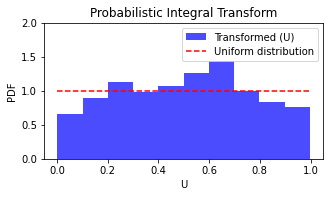

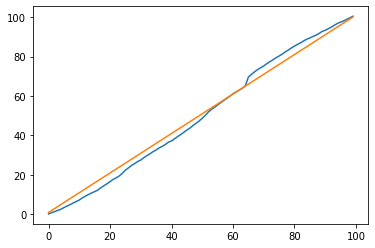

4.70764399316343

In [29]:
_PIT(
    np.stack(z_1_),
    nbins=10,
    file_name="{}_{}_{}-PIT-48.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_1_), nbins=100)

In [30]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 24

z_2_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        #         f_fc_ts_ = F_fc_ts_[d, t:, a]
        #         f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if (_eCDF(f_ts_[i]) == 0.0) | (_eCDF(f_ts_[i]) == 1.0):
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_2_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


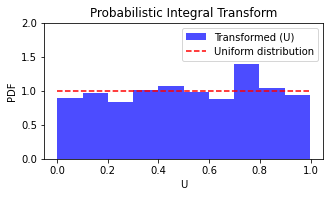

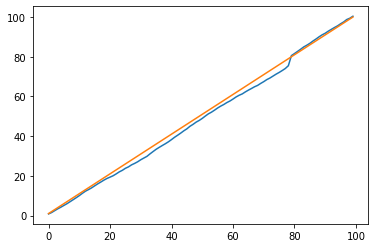

3.959867361862436

In [31]:
_PIT(
    np.stack(z_2_),
    nbins=10,
    file_name="{}_{}_{}-PIT-24.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_2_), nbins=100)

In [32]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 12
z_3_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_3_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


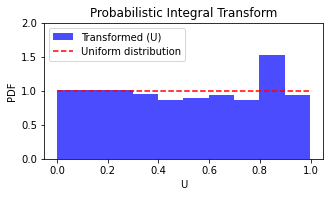

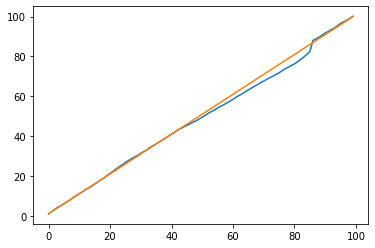

4.725702333503818

In [33]:
_PIT(
    np.stack(z_3_),
    nbins=10,
    file_name="{}_{}_{}-PIT-12.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_3_), nbins=100)

In [34]:
t = 144
forget_rate = 2
n_kNNs = 500

i = 60
z_4_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(36):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_4_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


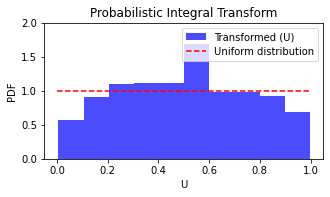

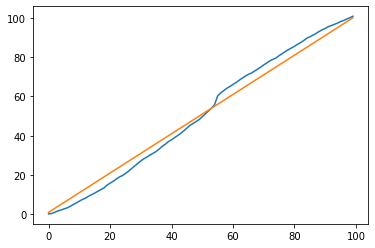

5.577859645969987

In [35]:
_PIT(
    np.stack(z_4_),
    nbins=10,
    file_name="{}_{}_{}-PIT-60.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_4_), nbins=100)

In [ ]:
# # Forecast dynamic update based on distance
# def _ffc_predict(_model, f_, fc_):

#     F_ = _model['F_tr_']

#     # Smoothing observed mean and actuals
#     if (_model['smoothing'] == 1) | (_model['smoothing'] == 3):
#         F_, f_ = _smoothing(F_, f_, _model['lambda'])

#     # phi: importance weights based on time distance
#     phi_ = _exponential_decay_minus(f_.shape[0], _model['forget_rate'])

#     # plt.figure(figsize = (10, 2))
#     # plt.title('Forget Rate')
#     # plt.plot(phi_)
#     # plt.ylim(-0.1,1.1)
#     # plt.show()

#     # d: euclidian distance between samples weighted by importance weights (phi)
#     d_ = _dist(F_, f_, phi_/phi_.sum())
#     # w: normalized wieghts distance across observations based on RBF kernel distance
#     w_ = _kernel(d_, _model['length_scale'])

#     _model['weights'] = w_/w_.sum()

#     # Multivariate normal assumption
#     _model = _predictive_multivariate_normal_dist(_model, fc_)

#     return _model

# Multivariate normal forecast assumption
# def _predictive_multivariate_normal_dist(_model, fc_):

#     F_ = _model['F_ts_']
#     w_ = _model['weights']

#     # Mean function
#     f_hat_ = F_.T @ w_

#     # Regulate mean function
#     f_hat_ = _gen_constraint(f_hat_, _model['f_min'], _model['f_max'])

#     # Smoothing prediction: unobserved mean and actuals
#     if (_model['smoothing'] == 2) | (_model['smoothing'] == 3):
#         F_, f_hat_ = _smoothing(F_, f_hat_, _model['lambda'])

#     # Fuse day-ahead forecast with real-time forecast
#     mu_hat_ = _update_forecast(F_, f_hat_, fc_, _model['trust_rate'])

#     # Covariance function
#     F_hat_ = np.repeat(mu_hat_[:, np.newaxis], F_.shape[0], axis = 1).T
#     S_hat_ = (F_ - F_hat_).T @ np.diag(w_) @ (F_ - F_hat_)

#     # plt.figure(figsize = (10, 2))
#     # plt.plot(f_hat_, label = 'real-time (fc)')
#     # plt.plot(fc_, label = 'day-ahead (fc)')
#     # plt.plot(mu_hat_, label = 'update (fc)')
#     # plt.ylim(-0.1,)
#     # plt.legend()
#     # plt.show()

#     # Define probability dist
#     _N = multivariate_normal(mu_hat_, S_hat_, allow_singular = True)

#     _model['normal'] = {}
#     _model['normal']['mean']         = mu_hat_
#     _model['normal']['covariance']   = S_hat_
#     _model['normal']['distribution'] = _N

#     return _model.copy()